In [ ]:
import sys
import os
import torch
import torch.distributed as dist
import torchsummary
import torch.optim as optim
import numpy as np
import torchvision.utils
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch import nn, Tensor
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from PIL import Image
from CustomDataset import CustomDataset
from metrics import evaluate

transform = v2.Compose([
    # v2.Resize((224,224)),
    # v2.RandomRotation(degrees=(0,180)),
    v2.Compose([v2.ToImage(),v2.ToDtype(torch.float32,scale=True)]),
    # v2.Normalize([0.485], [0.229]),
])
train_dataset = CustomDataset(root_dir="../training",transform=transform)
val_dataset = CustomDataset(root_dir="../validation",transform=transform)

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=False)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False)

In [4]:
import torch
import torch.nn as nn

class UpScale(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(UpScale, self).__init__()
        # Upsample layer to increase spatial resolution
        self.up_sample = nn.Upsample(scale_factor=2)
        # Convolutional layer for feature extraction
        self.conv = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True)
        # Batch normalization layer for stabilization
        self.batch = nn.BatchNorm2d(ch_out)
        # ReLU activation function for introducing non-linearity
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Upsample input
        x = self.up_sample(x)
        # Convolution operation
        x = self.batch(self.conv(x))
        # ReLU activation
        x = self.relu(x)
        return x

class Recurrent_block(nn.Module):
    def __init__(self, channels_out, layers=2):
        super(Recurrent_block, self).__init__()
        # Number of recurrent layers
        self.layers = layers
        # Number of output channels
        self.channels_out = channels_out
        # Sequential convolutional layers for recurrent processing
        self.conv = nn.Sequential(
            nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Initialize x1
        x1 = 0
        # Perform recurrent processing
        for i in range(self.layers):
            if i == 0:
                # Initial convolution
                x1 = self.conv(x)
            # Recurrent convolution
            x1 = self.conv(x + x1)
        return x1

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        # Convolutional layers for feature transformation
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        # Convolutional layer for computing attention weights
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        # ReLU activation function
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        # Transform input features
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        # Compute attention map
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        # Apply attention to input features
        return x * psi

class CNN_Block(nn.Module):
    def __init__(self, ch_in, ch_out, t=2):
        super(CNN_Block, self).__init__()
        # Recurrent convolutional layers
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out, layers=t),
            Recurrent_block(ch_out, layers=t)
        )
        # 1x1 convolution for adjusting channel dimensions
        self.Conv1x1 = nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # Adjust input channels
        x = self.Conv1x1(x)
        # Recurrent processing
        x1 = self.RCNN(x)
        return x + x1

class R2AttUNet(nn.Module):
    def __init__(self, img_ch=1, output_ch=1, t=2):
        super(R2AttUNet, self).__init__()
        
        # Pooling and upsampling layers
        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        # Recurrent convolutional blocks
        self.RRCNN1 = CNN_Block(ch_in=img_ch, ch_out=64, t=t)
        self.RRCNN2 = CNN_Block(ch_in=64, ch_out=128, t=t)
        self.RRCNN3 = CNN_Block(ch_in=128, ch_out=256, t=t)
        self.RRCNN4 = CNN_Block(ch_in=256, ch_out=512, t=t)
        self.RRCNN5 = CNN_Block(ch_in=512, ch_out=1024, t=t)

        # Upsampling blocks
        self.Up5 = UpScale(ch_in=1024, ch_out=512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.UpRRCNN5 = CNN_Block(ch_in=1024, ch_out=512, t=t)
        
        self.Up4 = UpScale(ch_in=512, ch_out=256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.UpRRCNN4 = CNN_Block(ch_in=512, ch_out=256, t=t)
        
        self.Up3 = UpScale(ch_in=256, ch_out=128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.UpRRCNN3 = CNN_Block(ch_in=256, ch_out=128, t=t)
        
        self.Up2 = UpScale(ch_in=128, ch_out=64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.UpRRCNN2 = CNN_Block(ch_in=128, ch_out=64, t=t)

        # 1x1 convolution for output adjustment
        self.Conv1x1 = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # Encoding path
        x1 = self.RRCNN1(x)
        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)
        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)
        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # Decoding path
        d4 = self.Up4(x4)
        x3 = self.Att4(g=d4, x=x3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.UpRRCNN4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=x2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.UpRRCNN3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=x1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.UpRRCNN2(d2)

        d1 = self.Conv1x1(d2)

        return d1


## Attention Unet Architecture

<p>Oktay, Ozan, Jo Schlemper, Loic Le Folgoc, Matthew Lee, Mattias Heinrich, Kazunari Misawa, Kensaku Mori et al. "Attention u-net: Learning where to look for the pancreas." arXiv preprint arXiv:1804.03999 (2018).</p>

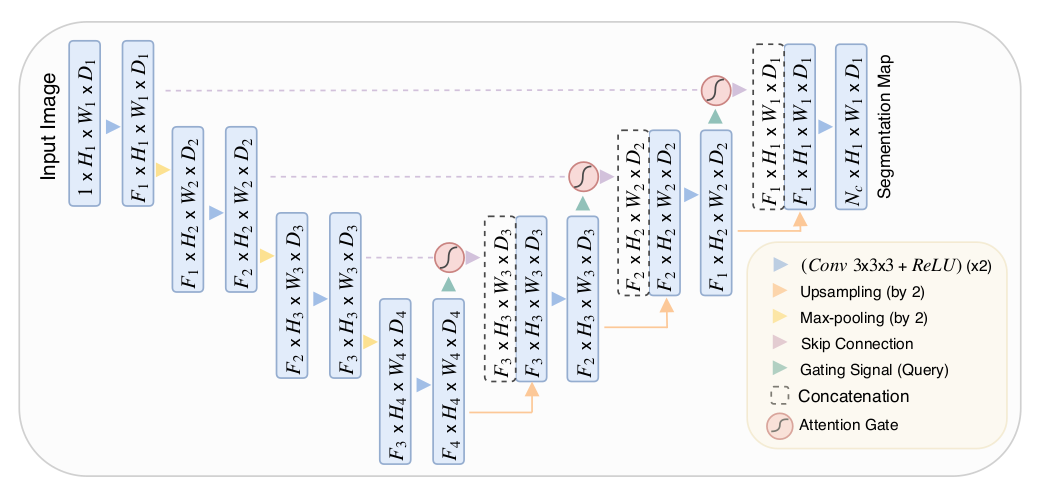

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = R2AttU_Net(img_ch=1).to(device)

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss)
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        if val_loss < self.val_loss_min:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            self.val_loss_min = val_loss


In [7]:
early_stopping = EarlyStopping(patience=10, delta=0.001)

In [8]:
import matplotlib.pyplot as plt
import wandb

device = torch.device('cuda')
logs = wandb.init(project="Attention Unet model")
criterion = nn.BCELoss()

# Using Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
best_acc = 0
num_epochs = 100 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    # Going through all the training data
    for data in train_loader:
        # extracting the images, masks, eye_masks from the dataloader
        for images, masks, eye_masks in data:
            images = images.to(device)
            masks = masks.to(device)
            # Pushing the images, masks to the GPU.
            optimizer.zero_grad()
            
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            # Calculating the loss
            loss = criterion(outputs, masks.float())
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    # Getting all the performance metrics
    acc, se, sp, F1, pr, AUC_ROC, dice, iou = evaluate(model, val_loader, num_classes=2)
    logs.log({
        "acc": acc,
        "sensitivity": se,
        "specificity": sp,
        "F1-score": F1,
        "AUC_ROC": AUC_ROC,
        "Dice": dice,
        "epoch": epoch,
        "IOU": iou
    })
    # Selecting best accuracy
    if best_acc < acc:
        best_acc = acc
        print(f"Best accuracy attained: {best_acc*100:.4f}%")
        torch.save(model.state_dict(),"Attention_unet_model.pth")
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {acc*100:.4f}%, IOU: {iou}')

wandb: Currently logged in as: battulasaikiran2002. Use `wandb login --relogin` to force relogin


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.47s/it]


Best accuracy attained: 62.1193%
Epoch [1/100], Loss: 48.6175, Accuracy: 62.1193%, IOU: 0.2555558852496601


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.59s/it]


Best accuracy attained: 88.6110%
Epoch [2/100], Loss: 36.6099, Accuracy: 88.6110%, IOU: 0.08556637863983356


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.42s/it]


Epoch [3/100], Loss: 33.4174, Accuracy: 88.5493%, IOU: 0.08823550789993966


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.56s/it]


Epoch [4/100], Loss: 30.8920, Accuracy: 88.2927%, IOU: 0.08419697384150433


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.37s/it]


Epoch [5/100], Loss: 28.7103, Accuracy: 88.2329%, IOU: 0.09791422436412955


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.36s/it]


Epoch [6/100], Loss: 27.4781, Accuracy: 88.2394%, IOU: 0.10061757204793616


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.34s/it]


Best accuracy attained: 89.3517%
Epoch [7/100], Loss: 25.9530, Accuracy: 89.3517%, IOU: 0.1958447376532214


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.35s/it]


Epoch [8/100], Loss: 25.2498, Accuracy: 88.2400%, IOU: 0.11526076406506555


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.43s/it]


Epoch [9/100], Loss: 29.3282, Accuracy: 88.4395%, IOU: 0.1211104973973263


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.35s/it]


Best accuracy attained: 89.7147%
Epoch [10/100], Loss: 25.4324, Accuracy: 89.7147%, IOU: 0.1625624614623597


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.66s/it]


Best accuracy attained: 90.3759%
Epoch [11/100], Loss: 23.9454, Accuracy: 90.3759%, IOU: 0.2909495354763099


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [12/100], Loss: 23.4115, Accuracy: 86.0272%, IOU: 0.2141837558975177


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.40s/it]


Best accuracy attained: 91.0168%
Epoch [13/100], Loss: 23.7768, Accuracy: 91.0168%, IOU: 0.24760704810420672


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [14/100], Loss: 23.3578, Accuracy: 89.6525%, IOU: 0.17543456605857327


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [15/100], Loss: 22.1711, Accuracy: 89.4864%, IOU: 0.1552278907260015


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Best accuracy attained: 91.9416%
Epoch [16/100], Loss: 25.9047, Accuracy: 91.9416%, IOU: 0.31678768925013995


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [17/100], Loss: 22.7934, Accuracy: 81.6637%, IOU: 0.24204959686668145


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [18/100], Loss: 21.8710, Accuracy: 88.9584%, IOU: 0.21401290221228486


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.47s/it]


Epoch [19/100], Loss: 21.3868, Accuracy: 88.6898%, IOU: 0.10264963448335905


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [20/100], Loss: 21.6551, Accuracy: 87.5959%, IOU: 0.145093127929916


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [21/100], Loss: 24.6900, Accuracy: 91.3850%, IOU: 0.3557248034292743


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [22/100], Loss: 23.5946, Accuracy: 54.4515%, IOU: 0.22685098340291351


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [23/100], Loss: 21.2784, Accuracy: 36.9227%, IOU: 0.1784215644977632


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [24/100], Loss: 20.6419, Accuracy: 78.5965%, IOU: 0.3315098986029625


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.31s/it]


Epoch [25/100], Loss: 20.2111, Accuracy: 40.3602%, IOU: 0.16589733266404696


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.30s/it]


Epoch [26/100], Loss: 19.9890, Accuracy: 63.6958%, IOU: 0.23664391122625342


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [27/100], Loss: 19.6964, Accuracy: 46.6859%, IOU: 0.21372432416260598


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.30s/it]


Epoch [28/100], Loss: 22.5624, Accuracy: 63.1206%, IOU: 0.2820931557122441


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.31s/it]


Epoch [29/100], Loss: 21.6110, Accuracy: 79.9342%, IOU: 0.352172153580579


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.31s/it]


Epoch [30/100], Loss: 19.9549, Accuracy: 46.3432%, IOU: 0.1824493813018004


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.31s/it]


Epoch [31/100], Loss: 19.3239, Accuracy: 74.6144%, IOU: 0.24506690730562522


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.39s/it]


Epoch [32/100], Loss: 19.5547, Accuracy: 33.2234%, IOU: 0.1628788255953363


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.38s/it]


Epoch [33/100], Loss: 18.5017, Accuracy: 28.7139%, IOU: 0.12415909300602618


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [34/100], Loss: 19.8472, Accuracy: 27.1358%, IOU: 0.14794782538499152


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.34s/it]


Epoch [35/100], Loss: 23.2811, Accuracy: 88.5441%, IOU: 0.14152782939019656


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.34s/it]


Epoch [36/100], Loss: 20.4018, Accuracy: 90.0113%, IOU: 0.22231426428826082


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.31s/it]


Epoch [37/100], Loss: 18.2651, Accuracy: 21.7306%, IOU: 0.13697665424662686


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.31s/it]


Epoch [38/100], Loss: 18.4027, Accuracy: 29.1741%, IOU: 0.13403701613701524


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.47s/it]


Epoch [39/100], Loss: 17.4916, Accuracy: 21.2231%, IOU: 0.12941021276637912


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [40/100], Loss: 17.0610, Accuracy: 58.2484%, IOU: 0.17052658889442682


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [41/100], Loss: 18.1260, Accuracy: 42.7103%, IOU: 0.1696483895226958


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [42/100], Loss: 16.3956, Accuracy: 68.4833%, IOU: 0.20378574174607084


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [43/100], Loss: 15.7999, Accuracy: 43.9001%, IOU: 0.16629376539162227


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [44/100], Loss: 15.5245, Accuracy: 85.2013%, IOU: 0.11986122615635394


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.31s/it]


Epoch [45/100], Loss: 15.5205, Accuracy: 20.0419%, IOU: 0.12486559464817955


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.40s/it]


Epoch [46/100], Loss: 16.1816, Accuracy: 31.5939%, IOU: 0.13584678262649547


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [47/100], Loss: 15.8101, Accuracy: 34.5410%, IOU: 0.13918974719320734


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [48/100], Loss: 14.9833, Accuracy: 18.6760%, IOU: 0.12839380250356736


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [49/100], Loss: 14.5967, Accuracy: 64.9773%, IOU: 0.21639328813623815


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [50/100], Loss: 14.2217, Accuracy: 54.9995%, IOU: 0.18704455289102737


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [51/100], Loss: 14.0101, Accuracy: 43.2588%, IOU: 0.16457496478798844


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.41s/it]


Epoch [52/100], Loss: 14.1154, Accuracy: 29.8230%, IOU: 0.14889728817201797


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [53/100], Loss: 13.3688, Accuracy: 69.8826%, IOU: 0.12857027180670272


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.40s/it]


Epoch [54/100], Loss: 13.3172, Accuracy: 28.7081%, IOU: 0.13276225428229996


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [55/100], Loss: 12.9190, Accuracy: 25.9228%, IOU: 0.1356699386168094


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [56/100], Loss: 13.4907, Accuracy: 44.3740%, IOU: 0.14049403036811522


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [57/100], Loss: 12.2140, Accuracy: 32.7096%, IOU: 0.12948152557724998


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [58/100], Loss: 11.9928, Accuracy: 55.7044%, IOU: 0.11060018693762166


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [59/100], Loss: 12.1745, Accuracy: 70.5829%, IOU: 0.20374210288836841


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.39s/it]


Epoch [60/100], Loss: 12.2619, Accuracy: 85.8609%, IOU: 0.1363296470471791


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [61/100], Loss: 12.0138, Accuracy: 77.1848%, IOU: 0.09687712926949774


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [62/100], Loss: 12.1847, Accuracy: 40.4434%, IOU: 0.1418970722084244


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.48s/it]


Epoch [63/100], Loss: 11.9421, Accuracy: 25.4603%, IOU: 0.1158012004835265


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [64/100], Loss: 12.2824, Accuracy: 26.1867%, IOU: 0.12052286650453295


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [65/100], Loss: 11.5541, Accuracy: 62.3001%, IOU: 0.15334252016175362


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [66/100], Loss: 15.2630, Accuracy: 20.8563%, IOU: 0.12025517126811403


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [67/100], Loss: 12.2028, Accuracy: 27.8124%, IOU: 0.13190518178577934


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.31s/it]


Epoch [68/100], Loss: 11.5946, Accuracy: 18.7337%, IOU: 0.11761816711652846


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [69/100], Loss: 10.7509, Accuracy: 84.4745%, IOU: 0.05423529050091193


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [70/100], Loss: 11.0688, Accuracy: 23.4694%, IOU: 0.10545503683388233


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [71/100], Loss: 10.6660, Accuracy: 35.1815%, IOU: 0.1279641698691107


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [72/100], Loss: 10.8887, Accuracy: 23.4237%, IOU: 0.12558110631292774


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.40s/it]


Epoch [73/100], Loss: 10.4627, Accuracy: 28.7000%, IOU: 0.12875999607855365


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [74/100], Loss: 10.6632, Accuracy: 41.2211%, IOU: 0.14093568301981405


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.39s/it]


Epoch [75/100], Loss: 11.7752, Accuracy: 30.1004%, IOU: 0.13434549602014678


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [76/100], Loss: 10.7469, Accuracy: 81.6963%, IOU: 0.18137960409124693


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [77/100], Loss: 11.0089, Accuracy: 74.4298%, IOU: 0.1404323845037392


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [78/100], Loss: 14.9502, Accuracy: 80.0074%, IOU: 0.05644347893428944


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [79/100], Loss: 11.8163, Accuracy: 86.5080%, IOU: 0.09728160591884738


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.31s/it]


Epoch [80/100], Loss: 11.2857, Accuracy: 87.5733%, IOU: 0.14259555137583188


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [81/100], Loss: 10.4078, Accuracy: 66.9171%, IOU: 0.11077180880875814


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [82/100], Loss: 10.3471, Accuracy: 67.0318%, IOU: 0.13065609224140645


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [83/100], Loss: 10.2779, Accuracy: 34.4417%, IOU: 0.1265096951276064


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [84/100], Loss: 10.2323, Accuracy: 86.4073%, IOU: 0.05245340787916489


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [85/100], Loss: 10.3648, Accuracy: 14.6089%, IOU: 0.11320587202374424


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [86/100], Loss: 9.7389, Accuracy: 44.4150%, IOU: 0.12071913173865705


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.36s/it]


Epoch [87/100], Loss: 10.0380, Accuracy: 38.4165%, IOU: 0.10883161324475493


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.34s/it]


Epoch [88/100], Loss: 9.8400, Accuracy: 24.3811%, IOU: 0.11971012006203334


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [89/100], Loss: 9.6513, Accuracy: 27.1582%, IOU: 0.1242253123649529


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [90/100], Loss: 9.5990, Accuracy: 59.7214%, IOU: 0.18279308501098837


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.31s/it]


Epoch [91/100], Loss: 9.5194, Accuracy: 27.5934%, IOU: 0.11805432377649205


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [92/100], Loss: 9.9116, Accuracy: 76.3745%, IOU: 0.2396933770605496


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [93/100], Loss: 10.0860, Accuracy: 69.3219%, IOU: 0.1604107762021678


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [94/100], Loss: 10.5835, Accuracy: 73.1020%, IOU: 0.1107233237297762


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [95/100], Loss: 10.3462, Accuracy: 84.8915%, IOU: 0.09606589599556867


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [96/100], Loss: 10.8432, Accuracy: 73.1454%, IOU: 0.15660508764641626


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [97/100], Loss: 10.2715, Accuracy: 18.8033%, IOU: 0.12034172879620678


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [98/100], Loss: 9.9350, Accuracy: 41.3472%, IOU: 0.12813681214160863


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Epoch [99/100], Loss: 11.7665, Accuracy: 88.5006%, IOU: 0.06890368197346106


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Epoch [100/100], Loss: 14.3100, Accuracy: 27.2617%, IOU: 0.14024149628267402


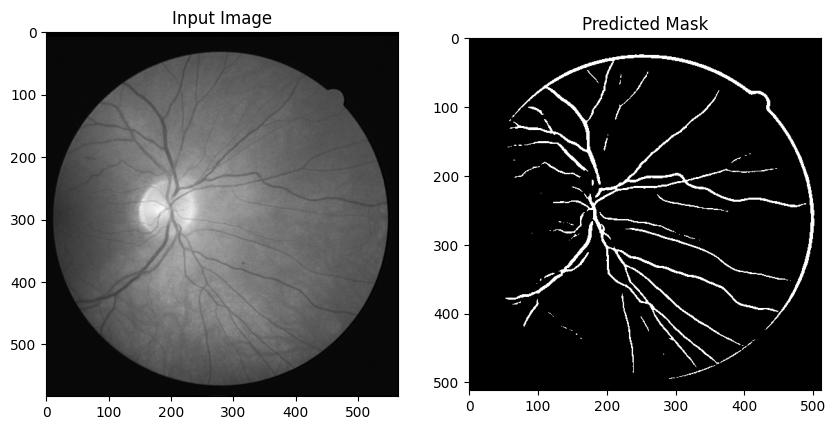

In [8]:
import torch
from torchvision import transforms
from PIL import Image

# Loading the saved model
model = R2AttU_Net(img_ch=1).to(device)
model.load_state_dict(torch.load("Attention_unet_model.pth"))
model.eval()

# Transforming the image
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])


input_image = Image.open('15_test.tif').convert('L')  
input_tensor = transform(input_image).unsqueeze(0) 

# Predicting
with torch.no_grad():
    output = model(input_tensor.cuda())


predicted_mask = (output > 0.5).float()

# Plotting the input and prediction mask
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image,cmap='gray')
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
plt.title('Predicted Mask')

plt.show()

In [14]:
torch.save(model.state_dict(),"AttentionCNN-latest.pth")